In [1]:
import os
import sys
from glob import glob
from tqdm import tqdm
import numpy as np
import pickle
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_pickle("../saved/sampled_proteins.pkl")
df.head()

,filename,rmsd,tm,ptm,len,recovery,seq
0,3p5pa02_seq30,2.260551,0.879183,0.79,202,0.301980,SNDDRKTAEIAQLKAKDADGDDHPYPPAKLQKVLNDQLANGAWKVA...
1,3p5pa02_seq40,1.364573,0.945448,0.72,202,0.336634,LLSPSQVAHVARLQATNARGEQEPRFKAALEVCRGSQLDNGSWGEA...
2,3p5pa02_seq26,1.723687,0.921527,0.84,202,0.351485,ARDAFGTAQVAQLKEPNPLGRLIPLYEGYLNYVSNHQLEDQSWGIE...
3,3p5pa02_seq62,1.414773,0.946349,0.84,202,0.316832,ENDHHEISHIALLQQTDIFGLKSPMFPSALTIVTEHREHNELWGVE...
4,3p5pa02_seq64,1.576217,0.936109,0.87,202,0.301980,KFDHYAVAAVATLYCRTCHERLAPAFPDALHFVQNHQLPNGRWGVK...


In [5]:
seq_to_tm = {}
seq_list = df['seq'].tolist()
tm_list = df['tm'].tolist()
for seq, tm in zip(seq_list, tm_list):
    seq_to_tm[seq] = tm

In [6]:
with open("../saved/RemoteFoldSet_domain_to_seqs.pkl", "rb") as f:
    domain_to_seqs = pickle.load(f)

In [7]:
def compute_tm(sampled_seqs):
    tms = []
    for a in range(len(sampled_seqs)):
        tm = seq_to_tm.get(sampled_seqs[a], None)
        if tm is not None:
            tms.append(tm)
    tm = np.mean(tms)
    return tm

In [8]:
domain_tm_len = {}
for domain, sampled_seqs in domain_to_seqs.items():
    tm = compute_tm(list(sampled_seqs))
    length = len(sampled_seqs[0])
    domain_tm_len[domain] = (tm, length)

In [9]:
# mean and std of domain_tm
mean_tm = np.mean([d for d, l in domain_tm_len.values()])
std_tm = np.std([d for d, l in domain_tm_len.values()])
print(f"Mean TM: {mean_tm:.4f}, Std TM: {std_tm:.4f}")

# mean and std of domain_length
mean_length = np.mean([l for d, l in domain_tm_len.values()])
std_length = np.std([l for d, l in domain_tm_len.values()])
print(f"Mean Length: {mean_length:.4f}, Std Length: {std_length:.4f}")

Mean TM: 0.9389, Std TM: 0.0234
Mean Length: 235.0444, Std Length: 117.6132


/tmp/ipykernel_1380225/4203504924.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  orig_cmap = cm.get_cmap('coolwarm')


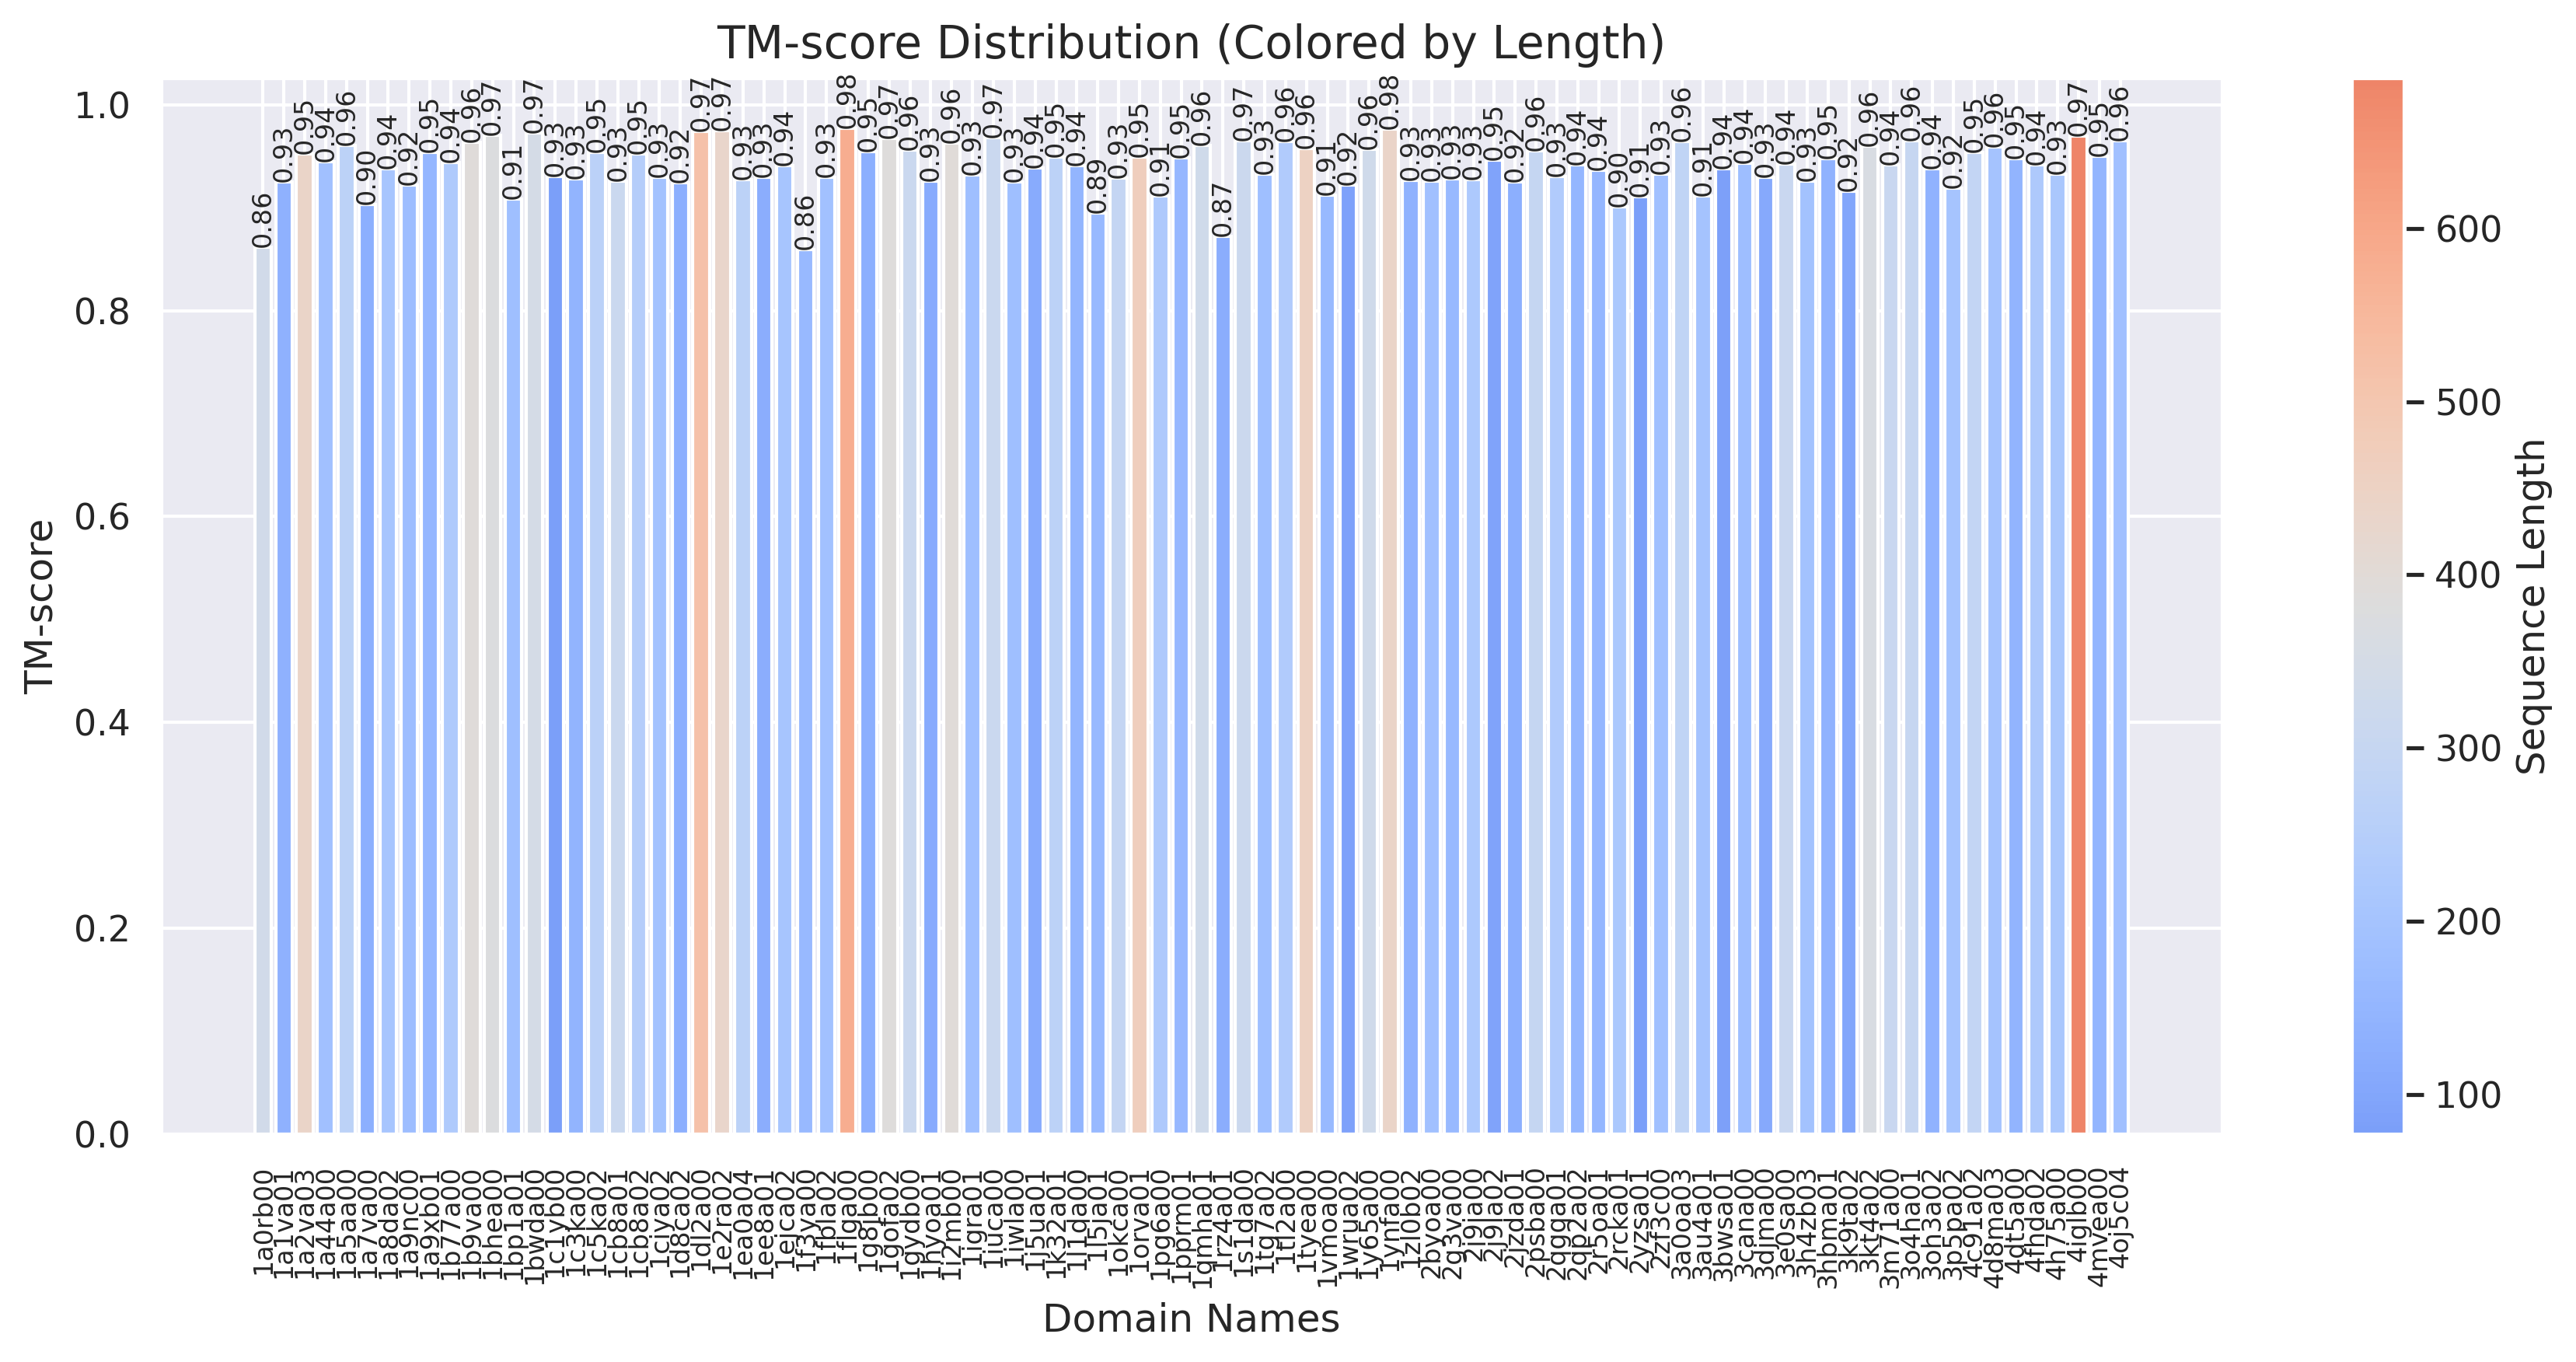

In [10]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, LinearSegmentedColormap

sns.set(style="darkgrid")

# Sort and unpack domain names and values
sorted_items = sorted(domain_tm_len.items(), key=lambda x: x[0])
names, values = zip(*sorted_items)
tms, lengths = zip(*values)

# Normalize length values (for color mapping)
norm = mcolors.Normalize(vmin=min(lengths), vmax=max(lengths))
orig_cmap = cm.get_cmap('coolwarm')
truncated_cmap = LinearSegmentedColormap.from_list(
    'truncated_pink',
    orig_cmap(np.linspace(0.2, 0.8, 256))
)

# Map length values to colors
colors = [truncated_cmap(norm(l)) for l in lengths]

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

# Create bar plot (height = tm, color = length)
bars = ax.bar(names, tms, color=colors)

# Annotate bars with tm values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f"{height:.2f}", ha='center', va='bottom',
            rotation=90, fontsize=8)

# Set axis labels and title
ax.set_xlabel('Domain Names', fontsize=12)
ax.set_ylabel('TM-score', fontsize=12)
ax.set_title('TM-score Distribution (Colored by Length)', fontsize=14)
ax.tick_params(axis='x', rotation=90, labelsize=8)

# Add colorbar for length
sm = cm.ScalarMappable(cmap=truncated_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Sequence Length', fontsize=12)

# Adjust layout and show plot
fig.tight_layout()
plt.show()
